# Inversion of pattern-forming PDE: Gierer-Meinhardt system

This notebook requires the new bayesflow package, currently found on the BayesFlow dev branch as of 3. December 2024.
It can be installed by uncommenting the following line.

In [1]:
#!pip install git+https://github.com/bayesflow-org/bayesflow.git@3f82ce1

In [2]:
import os

os.chdir("..")

In [3]:
import bayesflow as bf
import keras

2025-03-17 16:54:02.209054: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 16:54:02.211706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 16:54:02.219249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-17 16:54:02.230909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-17 16:54:02.234337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 16:54:02.244070: I tensorflow/core/platform/cpu_feature_gu

In [4]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "no"
from juliacall import Main as jl

jl.seval('import Pkg; Pkg.activate(".")')

jl.seval('include("src/simulations/modules.jl")')

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/code/PatternInference`


Main.GMStabilityAnalysis

In [5]:
jl.seval("using Distributions")

jl.seval("import .GiererMeinhardt")
jl.seval("import .GMStabilityAnalysis")
jl.seval("using .Samplers")

# Gierer Meinhardt System

The Gierer-Meinhardt system was proposed by Gierer and Meinhardt in 1972 and is a reaction-diffusion system of the activator-inhibitor type that appears to account for many important types of pattern formation and morphogenesis observed in development of organisms.

It is an example system showing diffusion driven (Turing) instability and consists of two chemicals that can react and have a different diffusion constant.

To see how the concentrations $u_1$ and $u_2$ subject to reaction and diffusion change, refer to the PDE

$$
\begin{align}
\partial_t u_1 =& a - b u_1 + \frac{u_1 ^2} {u_2 (1+c u_1^2)} &+ s \Delta u_1 \\
\partial_t u_2 =& u_1 ^2 - u_2 &+ \delta s \Delta u_2
\end{align}
$$ where $a$, $b$, $c$ and $\delta$ are unknown positive parameters.

To combine such structural knowledge (or hypothesis) with experimental data, we require to solve the following inverse problem:
Given an observation, determine all the model configurations that are able to produce it. In other words, what is the posterior probability $p(\theta|x_{obs})$ of all model configurations $\theta=(a, b, c, \delta)$ given some (set of) experimental data $x_{obs}$.

Classical statistical approaches like MCMC or ABC are infeasable as the likelihood density is not available, sampling it is still expensive and we lack a sensible distance measure in observation space (images of patterns). Consequentially, this problem has motivated the search for new methods based on e.g. hand-crafted Resistance Distance Histogram (RDH) statistics [1], or an artificial Correlation Integral Likelihood (CIL) applicable for a batch of observations [2], among others.

    [1] Schnörr, D., & Schnörr, C. (2021).
        Learning System Parameters from Turing Patterns
        (No. arXiv:2108.08542). arXiv. http://arxiv.org/abs/2108.08542
    
    
    [2] Kazarnikov, A., Scheichl, R., Haario, H., & Marciniak-Czochra, A. (2023).
        A Bayesian Approach to Modelling Biological Pattern Formation with Limited Data
        (No. arXiv:2203.14742). arXiv. http://arxiv.org/abs/2203.14742

This notebook presents the treatment by amortized Bayesian inference (ABI).

For this we require the ability to sample from the generative process. It consists of priors for the parameters and initial conditions and a likelihood which will be a PDE solve operation.

## Prior

In [6]:
def prior():
    """
    Sample from prior for a, b, c, delta, s, delta_x as in to [1].

    [1] Schnörr, D., & Schnörr, C. (2021).
        Learning System Parameters from Turing Patterns
        (No. arXiv:2108.08542). arXiv. http://arxiv.org/abs/2108.08542
    """
    parameters = np.array(jl.wide_prior_sampler())
    return dict(parameters=parameters)


def filtered_sampler(sampler, filter_function):
    candidate_sample = sampler()
    while not filter_function(candidate_sample):
        candidate_sample = sampler()
    return candidate_sample


def filtered_prior():
    """Rejects all parameter vectors that do not exhibit diffusion driven instability."""
    parameters = np.array(filtered_sampler(jl.wide_prior_sampler, jl.GMStabilityAnalysis.is_homogeneous_state_unstable))
    return dict(parameters=parameters)

## Initial conditions

In [7]:
def ic_sampler(parameters, domain_size=64):
    """Initializes the field with random perturbation around the fix point of the perfectly mixed system"""
    homogeneous_fix_point = np.array(jl.GMStabilityAnalysis.homogeneous_state(parameters))

    initial_conditions = homogeneous_fix_point[None, None, :] * (
        1 + 0.01 * np.random.rand(domain_size, domain_size, len(homogeneous_fix_point))
    )
    return dict(initial_conditions=initial_conditions)

## Solve partial differential equation

The PDE forward evolution is computationally expensive. We thus use fairly optimized solver code written in Julia that uses the powerful [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/dev/) package with a [Sundials](https://computing.llnl.gov/projects/sundials) solver.

In [8]:
def solve_final_state(parameters, initial_conditions, tspan=(0, 1000)):
    prob = jl.GiererMeinhardt.initialize_problem(jl.Array(parameters), jl.Array(initial_conditions), tspan)
    sol = jl.solve_final_state(
        jl.Array(parameters),
        jl.Array(initial_conditions),
        tspan,
        prob,
    )
    final_state = sol.u[-1][:, :, 0]
    return dict(final_states=final_state)

# Combine components into a simulator

In [9]:
simulator = bf.make_simulator([filtered_prior, ic_sampler, solve_final_state])  # , solve_final_state])

In [10]:
%%time
num_pattern_plots = 8
test_sims = simulator.sample(batch_size=num_pattern_plots)
print(test_sims["parameters"].shape)
print(test_sims["initial_conditions"].shape)
print(test_sims["final_states"].shape)

(8, 5)
(8, 64, 64, 2)
(8, 64, 64)
CPU times: user 1min 9s, sys: 244 ms, total: 1min 9s
Wall time: 1min 6s


In [11]:
# %%time # todo: parallelize online PDE solves. Currently SciML.jl's EnsembleProblem seems to have a memory leak
# when called from IPython that terminates the jupyter kernel.

# ens_sol = jl.solve_final_states_ensemble(
#    test_sims["parameters"],
#    test_sims["initial_conditions"],
#    (0, 1000), jl.GiererMeinhardt.initialize_problem
# )

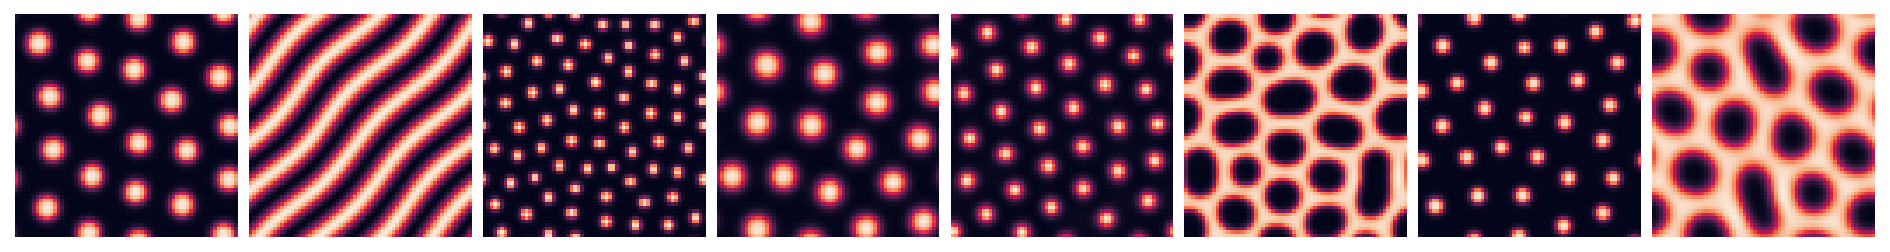

In [12]:
# | label: fig-patterns-prior-predictive-few
# | fig-cap: "Gierer Meinhardt: Fix points computed with CVode Backward Differentiation Formula (BDF) solver"
fix, ax = plt.subplots(1, num_pattern_plots, figsize=(2 * num_pattern_plots, 4), dpi=150)
for i in range(num_pattern_plots):
    img = sns.heatmap(test_sims["final_states"][i, :, :], ax=ax[i], square=True, cbar=False)
    img.set_xticks([])
    img.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [13]:
num_pattern_plots = 8

Those patterns above are simulated here in the notebook. Calling the simulator is too slow for online training, so I prepared offline datasets for training and validating which we will load next.

# Load prepared simulations 

In [14]:
training_budget = None  # 512  # None -> no cropping, use all available data.

In [15]:
def add_individual_sim_data_std(data_dict):
    "Adds a pattern standardized to stretch between -1 and 1 as a key value pair to `data_dict`."
    individual_minimum = np.min(
        data_dict["final_states"],
        axis=(
            1,
            2,
        ),
        keepdims=True,
    )
    individual_maximum = np.max(
        data_dict["final_states"],
        axis=(
            1,
            2,
        ),
        keepdims=True,
    )
    individual_ptp = individual_maximum - individual_minimum

    data_dict["final_states_std"] = ((data_dict["final_states"] - individual_minimum) / individual_ptp - 0.5) * 2


SIMS_PATH_TRAIN = "data/GM-001-slice-04000-20384-train.pkl"
with open(SIMS_PATH_TRAIN, "rb") as f:
    train_dict = pickle.load(f)
    train_dict["parameters"] = train_dict["parameters"][:, :4]
    add_individual_sim_data_std(train_dict)

    train_dict = {key: value[:training_budget, ...] for key, value in train_dict.items()}

SIMS_PATH_VAL = "data/GM-001-slice-00000-02000-validation.pkl"
with open(SIMS_PATH_VAL, "rb") as f:
    val_dict = pickle.load(f)
    val_dict["parameters"] = val_dict["parameters"][:, :4]
    add_individual_sim_data_std(val_dict)

for new_data_dict in (train_dict, val_dict):
    for key, value in new_data_dict.items():
        print(f"{key:20s} shape={str(value.shape):18s} min={np.min(value)}")
    print()

final_states         shape=(16384, 64, 64)    min=0.005279208189585102
initial_conditions   shape=(16384, 2, 64, 64) min=0.09597075521143582
parameters           shape=(16384, 4)         min=0.010001311912456666
final_states_std     shape=(16384, 64, 64)    min=-1.0

final_states         shape=(2000, 64, 64)     min=0.005986330524587994
initial_conditions   shape=(2000, 2, 64, 64)  min=0.09807058792046151
parameters           shape=(2000, 4)          min=0.010124940654895923
final_states_std     shape=(2000, 64, 64)     min=-1.0



## Look at some presimulated data

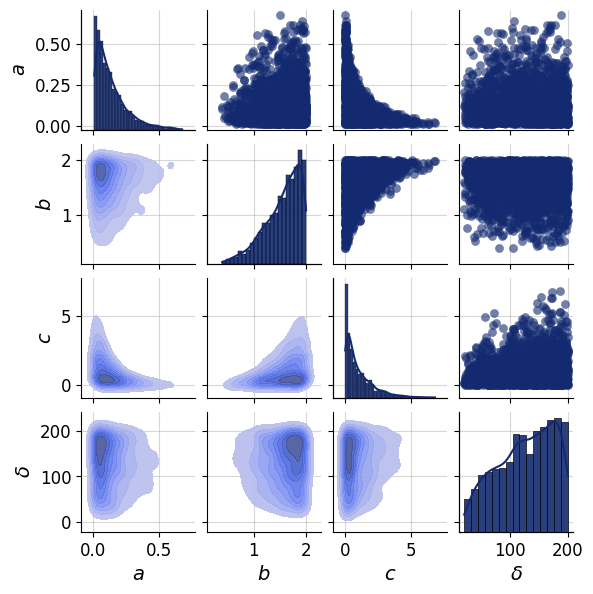

In [16]:
# | label: fig-parameters-prior
# | fig-cap: "Prior samples (filtered for Turing instability)"
variable_names = np.array(["$a$", "$b$", "$c$", r"$\delta$"])
f = bf.diagnostics.pairs_samples(val_dict, variable_keys=["parameters"], variable_names=variable_names, height=1.5)

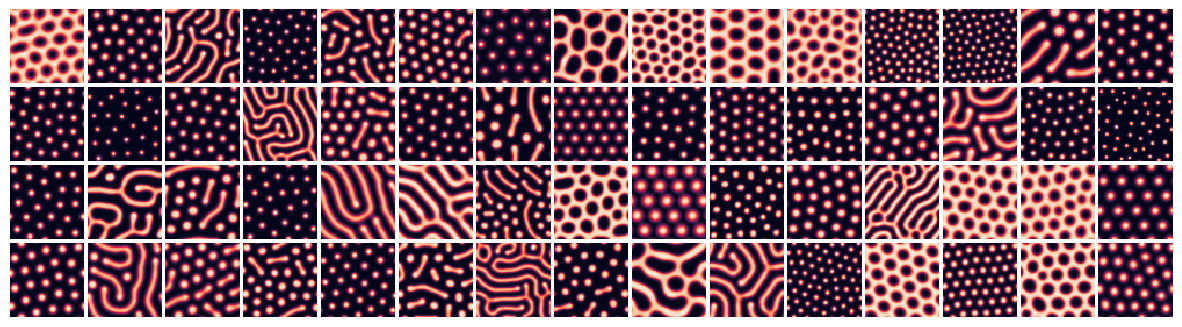

In [17]:
# | label: fig-patterns-prior-predictive-many
# | fig-cap: "Prior predictive samples"
num_pattern_plots = 60
columns = 15
num_h, num_v = num_pattern_plots // columns, columns
fix, axes = plt.subplots(num_h, num_v, figsize=(num_v, num_h))
for i, ax in enumerate(axes.flatten()):
    img = sns.heatmap(train_dict["final_states_std"][i], ax=ax, square=True, cbar=False)  # , cmap="icefire")
    img.set_xticks([])
    img.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Preprocessing

In [18]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .keep(["parameters", "final_states_std"])
    .constrain("parameters", lower=0)
    .rename("parameters", "inference_variables")
    .rename("final_states_std", "summary_variables")
    # .standardize(include="inference_variables", momentum=None, axis=0)
    .standardize(momentum=None)  # exclude=["patterns", "patterns_std"])
)

`OfflineDataset` objects will store both the training and the validation dataset, perform the adaptation and serve it batchwise with a fixed size.

In [19]:
batch_size = 32

training_dataset = bf.datasets.OfflineDataset(data=train_dict, batch_size=batch_size, adapter=adapter)

validation_dataset = bf.datasets.OfflineDataset(data=val_dict, batch_size=batch_size, adapter=adapter)

In [20]:
training_dataset.__getitem__(0)["summary_variables"].shape

(32, 64, 64)

# Build a CNN to summarize patterns

In [21]:
class PatternSummary(bf.networks.SummaryNetwork):
    def __init__(
        self,
        summary_dim,
        conv_params,
        num_fully_connected=15,
        conv_dropout_prob=0.0,
        dense_dropout_prob=0.0,
        kernel_regularizer="l1l2",
        **kwargs,
    ):
        """
        Create a pattern summary network with flexible convolutional layers, max-pooling, and dropout.

        Parameters
        ----------
        summary_dim : int
            The dimension of the summary statistics.
        conv_params : list of dict
            A list of dictionaries defining the parameters for convolutional layers, e.g.:
                - num_filters: int, number of filters for the Conv2D layer.
                - kernel_size: int or tuple, size of the kernel for the Conv2D layer.
                - pool_size: int or tuple, size of the max-pooling window (optional).
                - activation: str, activation function (default is 'relu').
        num_fully_connected : int, optional
            The number of units in the fully connected layer (default is 15).
        conv_dropout_prob : float, optional
            The dropout probability applied after each convolutional layer (default is 0.0).
        dense_dropout_prob : float, optional
            The dropout probability applied before the fully connected layer (default is 0.0).
        kernel_regularizer : string or keras.Regularizer object
            Regularization of convolutional and dense layers (default is "l1l2")
        kwargs : dict, optional
            Additional keyword arguments for the tf.keras.Model superclass.
        """
        super().__init__(**kwargs)
        self.summary_dim = summary_dim

        self.net = keras.models.Sequential()
        self.net.add(keras.layers.Lambda(lambda x: keras.ops.expand_dims(x, axis=-1)))

        for conv_param in conv_params:
            num_filters = conv_param.get("num_filters", 32)
            kernel_size = conv_param.get("kernel_size", 3)
            activation = conv_param.get("activation", "relu")
            pool_size = conv_param.get("pool_size", None)

            self.net.add(
                keras.layers.Conv2D(
                    num_filters, kernel_size, activation=activation, kernel_regularizer=kernel_regularizer
                )
            )

            if pool_size is not None:
                self.net.add(keras.layers.MaxPooling2D(pool_size))

            if conv_dropout_prob > 0:
                self.net.add(keras.layers.Dropout(conv_dropout_prob))

        self.net.add(keras.layers.Flatten())
        if dense_dropout_prob > 0:
            self.net.add(keras.layers.Dropout(dense_dropout_prob))
        self.net.add(keras.layers.Dense(num_fully_connected, activation="relu", kernel_regularizer=kernel_regularizer))
        self.net.add(keras.layers.Dense(summary_dim, kernel_regularizer=kernel_regularizer))

    def call(self, inputs, training: bool = False, **kwargs):
        return self.net(inputs)

In [22]:
conv_params = [
    {"num_filters": 32, "kernel_size": 3, "pool_size": 2},
    {"num_filters": 32, "kernel_size": 3, "pool_size": 2},
    {"num_filters": 32, "kernel_size": 3},
]
summary_dim = 6
summary_net_dropout = inference_net_dropout = 0.0
summary_net = PatternSummary(
    summary_dim=summary_dim,
    conv_params=conv_params,
    num_fully_connected=15,
    conv_dropout_prob=summary_net_dropout,
    dense_dropout_prob=summary_net_dropout,
    kernel_regularizer="l1l2",
)

# Setup an inference network for amortized posterior inference

In [23]:
inference_net = bf.networks.FlowMatching()  # (subnet_kwargs={"residual": True, "dropout": inference_net_dropout})
# inference_net = bf.networks.CouplingFlow()

In [24]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    checkpoint_filepath="checkpoints",
    checkpoint_name="run2",
)

Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)


In [25]:
history = workflow.fit_offline(
    train_dict,
    epochs=50,
    batch_size=batch_size,
    validation_data=val_dict,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.6244 - loss/inference_loss: 1.6244 - val_loss: 1.1329 - val_loss/inference_loss: 1.1329
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 1.0206 - loss/inference_loss: 1.0206 - val_loss: 0.8238 - val_loss/inference_loss: 0.8238
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.8349 - loss/inference_loss: 0.8349 - val_loss: 0.6475 - val_loss/inference_loss: 0.6475
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.7710 - loss/inference_loss: 0.7710 - val_loss: 0.8592 - val_loss/inference_loss: 0.8592
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.7419 - loss/inference_loss: 0.7419 - val_loss: 0.9557 - val_loss/inference_loss: 0.9557
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.7118 - loss/inference_loss: 0.7118 - val_loss: 0.8428 - val_loss/inference_loss: 0.8428
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.7037 - loss/inference_lo

INFO:bayesflow:Training is now finished.
            You can find the trained approximator at 'checkpoints/run2.run2.keras'.
            To load it, use approximator = keras.saving.load_model(...).


# Visualize losses


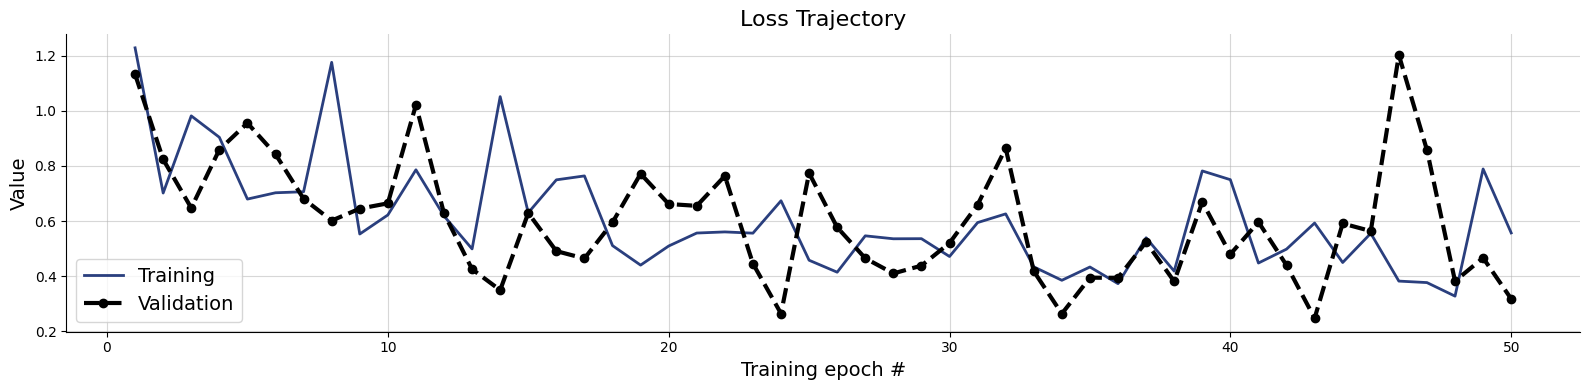

In [26]:
f = bf.diagnostics.loss(history)

# Diagnosing on held-out validation data

In [27]:
batch_size = 200
num_samples = 500
conditions = {k: v[:batch_size, ...] for k, v in val_dict.items()}

pdraws = workflow.approximator.sample(conditions=conditions, num_samples=num_samples)

In [28]:
conditions["parameters"].shape

(200, 4)

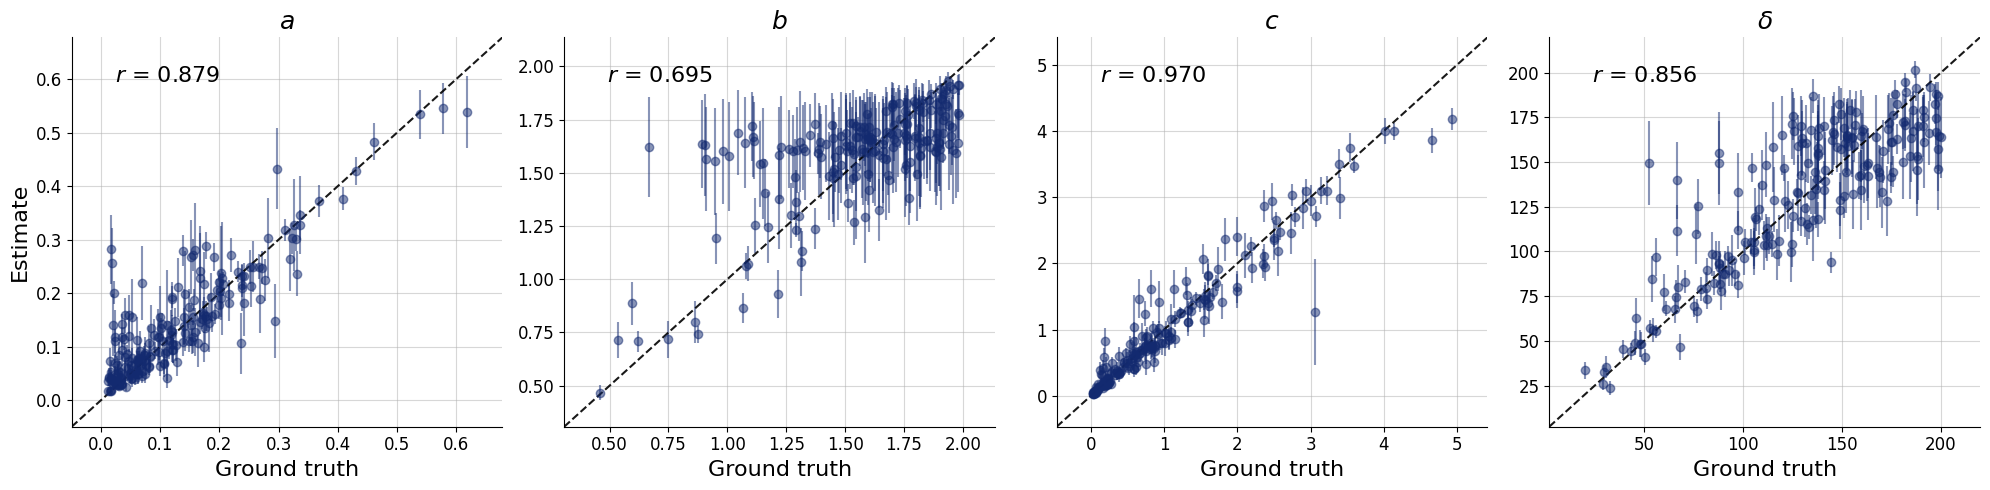

In [29]:
# | label: fig-recovery
# | fig-cap: "Recovery"
f = bf.diagnostics.plots.recovery(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], variable_names=variable_names
)

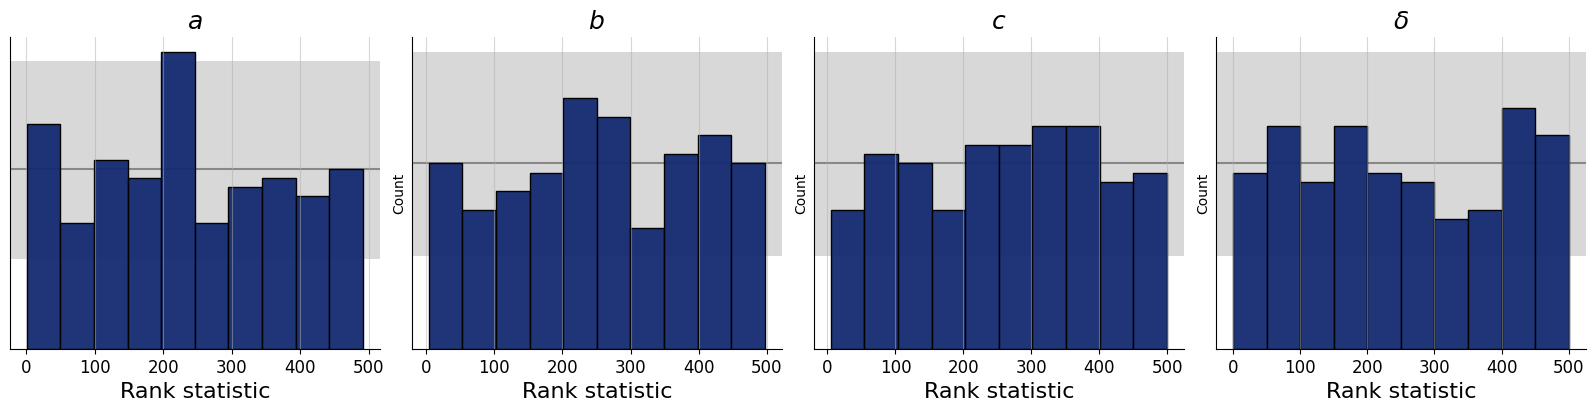

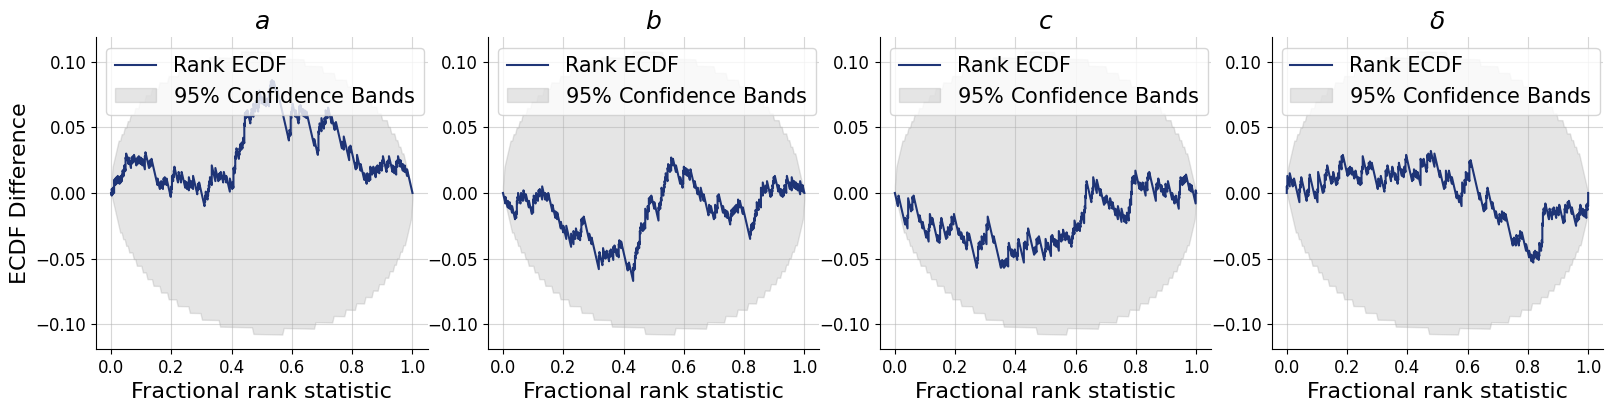

In [30]:
# | label: fig-cal
# | fig-cap: "Calibration"
# | fig-subcap:
# |   - "Histogram"
# |   - "ECDF difference"
# | layout-ncol: 2
f = bf.diagnostics.calibration_histogram(
    pdraws, val_dict["parameters"][:batch_size, ...], variable_names=np.array(variable_names)
)
f.set_size_inches(f.get_size_inches() * 0.8)

f = bf.diagnostics.calibration_ecdf(
    pdraws["parameters"],
    val_dict["parameters"][:batch_size, ...],
    difference=True,
    variable_names=variable_names,
    height=4,
)
f.set_size_inches(f.get_size_inches() * 0.8)
for ax in f.axes:
    ax.legend(fontsize=15, loc="upper left")

The posteriors are calibrated across the board and the accuracy (recovery) looks good.

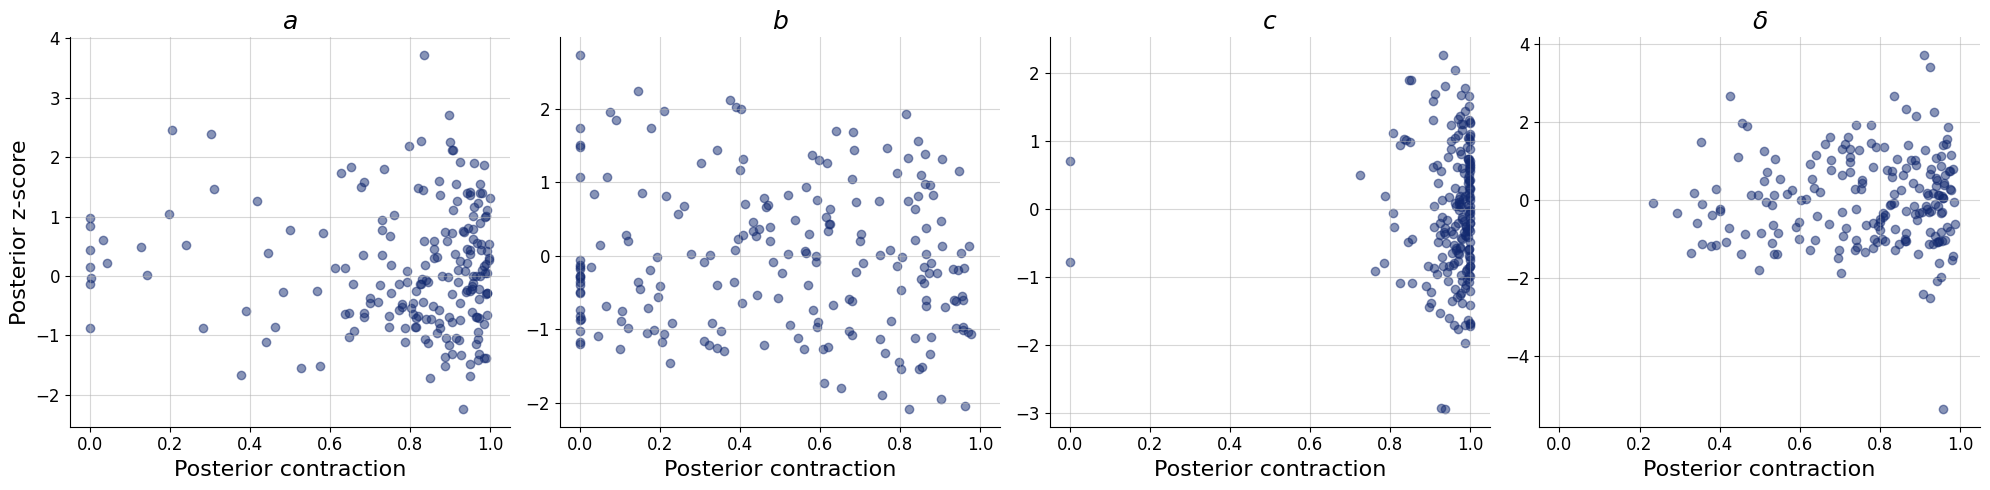

In [31]:
f = bf.diagnostics.plots.z_score_contraction(
    pdraws["parameters"], val_dict["parameters"][:batch_size, ...], variable_names=variable_names
)

# Inference

If the diagnostics are indicating a trustworthy model, we can continue with harvesting the fruit of our work: inferring full posterior distributions fast. We are using simulated observations here for which we know the true parameter (indicated by a green cross below).

Looking at a few simulated observations can provide an intuition for posterior shapes.

To further scrutinize the inferred posteriors, take a look at the posterior predictive samples. Those are the result of generating fresh patterns that correspond to posterior samples. Are they visually similar to the original observation we conditioned on? In line with what we saw in the recovery diagnostic, this shows a mixed picture.

In [32]:
def resimulate(parameters, domain_size=64, tspan=(0, 1000)):
    batch_size = parameters.shape[0]
    final_states = np.empty((batch_size, domain_size, domain_size))

    for i in range(batch_size):
        param_longform = np.concatenate(
            [
                parameters[i],
                [
                    0.5,  # this parameter controls overall scale and was held constant
                ],
            ]
        )
        initial_conditions = ic_sampler(param_longform, domain_size)["initial_conditions"]
        final_states[i] = solve_final_state(param_longform, initial_conditions, tspan)["final_states"]

    return final_states

In [33]:
conditions.keys()

dict_keys(['final_states', 'initial_conditions', 'parameters', 'final_states_std'])

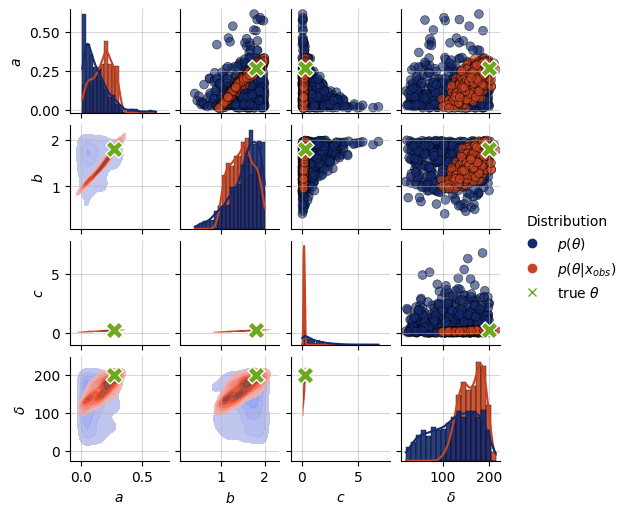

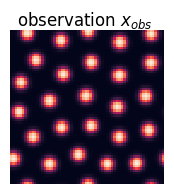

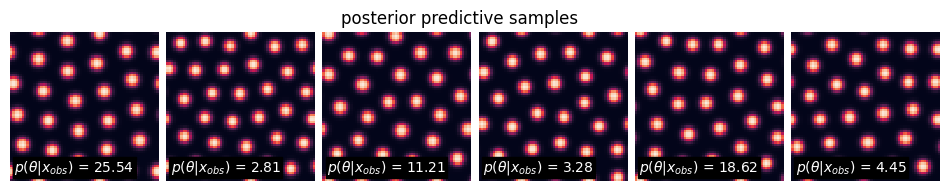

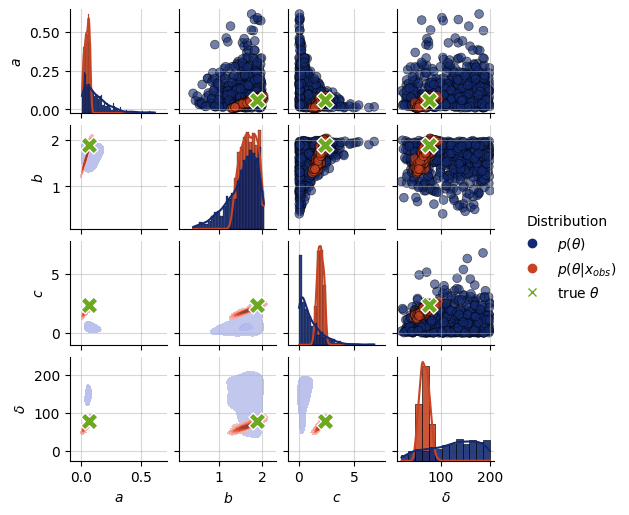

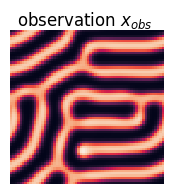

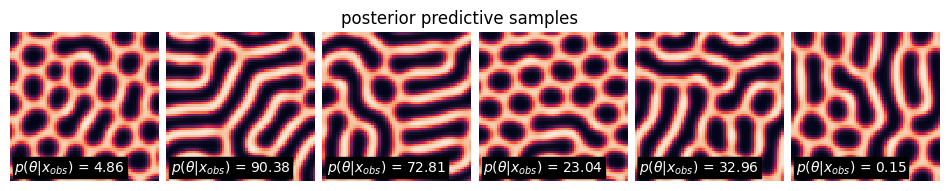

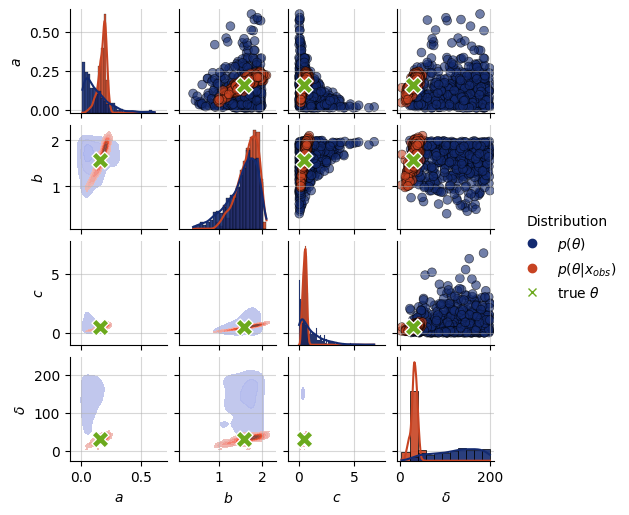

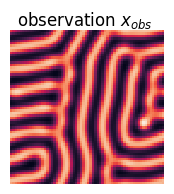

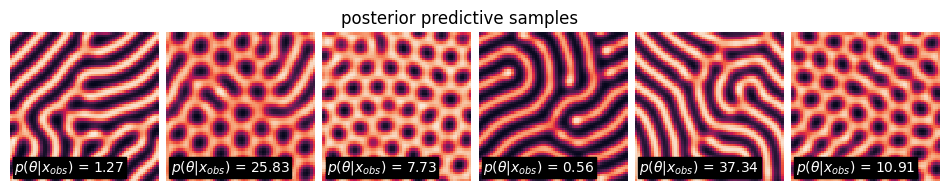

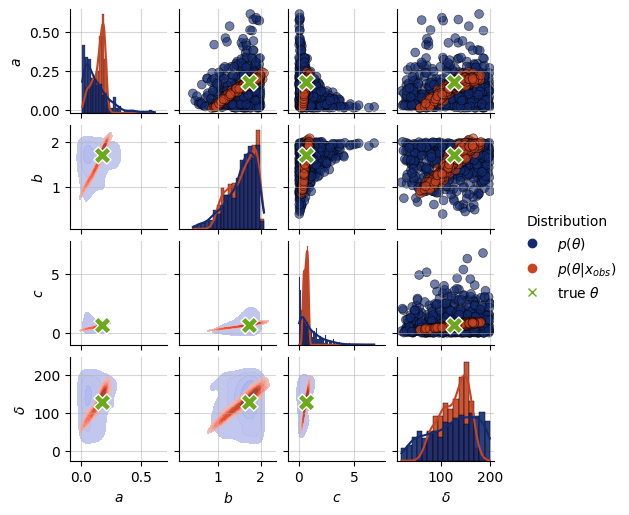

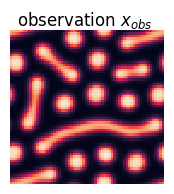

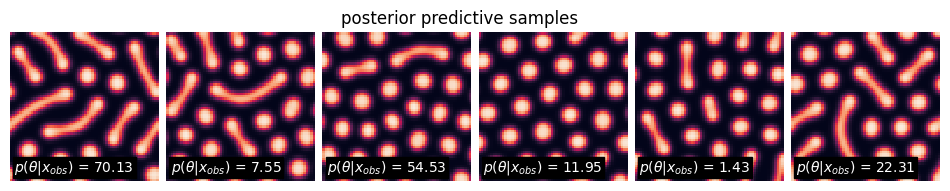

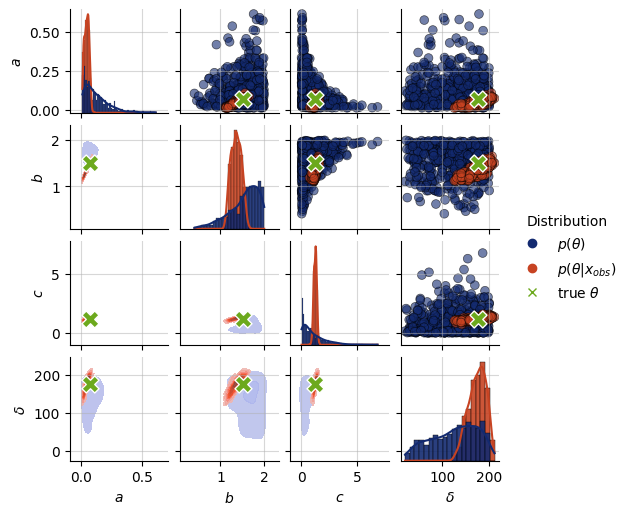

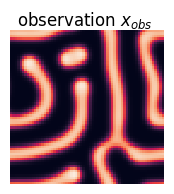

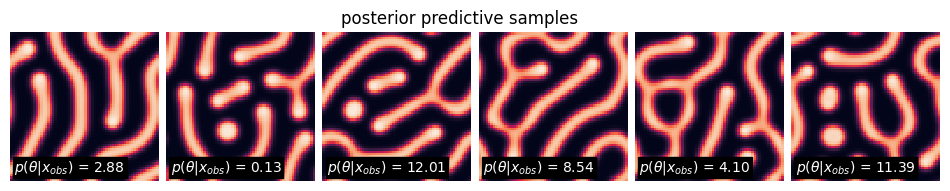

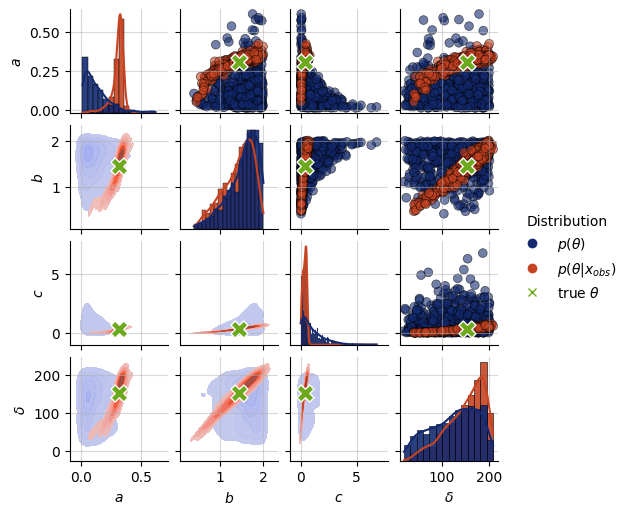

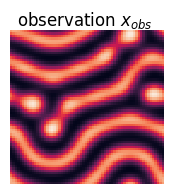

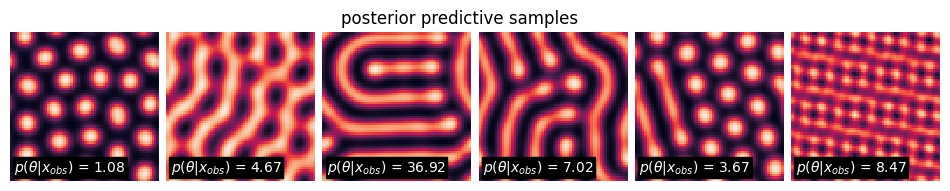

In [34]:
for obs_idx in range(7, 13):

    sample_dict = {}
    sample_dict[r"$p(\theta)$"] = pd.DataFrame(val_dict["parameters"][:num_samples, ...], columns=variable_names)
    sample_dict[r"$p(\theta|x_{obs})$"] = pd.DataFrame(pdraws["parameters"][obs_idx, ...], columns=variable_names)
    sample_dict[r"true $\theta$"] = pd.DataFrame(
        val_dict["parameters"][obs_idx, ...][None, ...], columns=variable_names
    )

    combined_samples = pd.concat(
        [samples.assign(Distribution=label) for label, samples in sample_dict.items()], axis="index", ignore_index=True
    )

    # palette = [sns.color_palette(palette="Set1")[i] for i in [1, 0, 2]]
    palette = ["#132a70", "#C74322", "#6CA91D"]
    g = sns.PairGrid(
        combined_samples, hue="Distribution", diag_sharey=False, palette=palette, height=1.3
    )  # , corner=False)
    g.map_upper(sns.scatterplot, alpha=0.6, s=40, edgecolor="k", marker="o")
    g.map_lower(sns.kdeplot, fill=True, warn_singular=False, bw_adjust=0.9, alpha=0.9)  # , levels=6)
    g.map_diag(sns.histplot, fill=True, alpha=0.9, kde=True)  # , bins=6)

    g.data = combined_samples.iloc[-1:]
    g.map_lower(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)
    g.map_upper(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)

    for i in range(len(variable_names)):
        for j in range(len(variable_names)):
            g.axes[i, j].grid(alpha=0.5)

    handles = [
        Line2D([], [], color=color, ls="", marker=marker, label=label)
        for label, color, marker in zip(combined_samples["Distribution"].unique(), palette, ["o", "o", "x"])
    ]

    g.add_legend(handles=handles)
    g.tight_layout()

    fig, ax = plt.subplots(figsize=(2, 2))
    img = sns.heatmap(val_dict["final_states_std"][obs_idx, ...], ax=ax, square=True, cbar=False)  # , cmap="icefire")
    img.set_xticks([])
    img.set_yticks([])
    fig.suptitle(r"observation $x_{obs}$")
    plt.show()

    num_resims = 6
    resim_params = pdraws["parameters"][obs_idx, :num_resims]
    resim_patterns = np.tile(conditions["final_states_std"][obs_idx, :, :], (num_resims, 1, 1))
    log_prob_posterior_samples = np.exp(
        workflow.approximator.log_prob(dict(parameters=resim_params, final_states_std=resim_patterns))
    )

    resim_final_states = resimulate(resim_params)

    num_h, num_v = 1, num_resims
    fig, axes = plt.subplots(num_h, num_v, figsize=(num_v * 2, num_h * 2))
    for i, ax in enumerate(axes.flatten()):
        img = sns.heatmap(resim_final_states[i], ax=ax, square=True, cbar=False)  # , cmap="icefire")
        img.set_xticks([])
        img.set_yticks([])
        img.text(
            0.03,
            0.03,
            r"$p(\theta|x_{obs})$ " + f"= {log_prob_posterior_samples[i]:.2f}",
            ha="left",
            va="bottom",
            transform=img.transAxes,
            color="white",
            size=10,
            bbox=dict(facecolor="none", pad=1.0, fc="black"),
        )

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.suptitle("posterior predictive samples")
    plt.show()

In [35]:
keras.tree.map_structure(keras.ops.shape, conditions)

{'final_states': (200, 64, 64),
 'initial_conditions': (200, 2, 64, 64),
 'parameters': (200, 4),
 'final_states_std': (200, 64, 64)}

In [36]:
resim_patterns.shape, resim_params.shape

((6, 64, 64), (6, 4))

In [37]:
conditions["parameters"].shape

(200, 4)

In [38]:
def plot_posterior(obs_idx, height=1.5, dpi=100):
    sample_dict = {}
    sample_dict[r"$p(\theta)$"] = pd.DataFrame(val_dict["parameters"][:num_samples, ...], columns=variable_names)
    sample_dict[r"$p(\theta|x_{obs})$"] = pd.DataFrame(pdraws["parameters"][obs_idx, ...], columns=variable_names)
    sample_dict[r"true $\theta$"] = pd.DataFrame(
        val_dict["parameters"][obs_idx, ...][None, ...], columns=variable_names
    )

    combined_samples = pd.concat(
        [samples.assign(Distribution=label) for label, samples in sample_dict.items()], axis="index", ignore_index=True
    )

    # palette = [sns.color_palette(palette="Set1")[i] for i in [1, 0, 2]]
    palette = ["#132a70", "#C74322", "#6CA91D"]
    g = sns.PairGrid(
        combined_samples, hue="Distribution", diag_sharey=False, palette=palette, height=height
    )  # , corner=False)
    g.map_upper(sns.scatterplot, alpha=0.6, s=40, edgecolor="k", marker="o")
    g.map_lower(sns.kdeplot, fill=True, warn_singular=False, bw_adjust=0.9, alpha=0.9)  # , levels=6)
    g.map_diag(sns.histplot, fill=True, alpha=0.9, kde=True)  # , bins=6)

    g.data = combined_samples.iloc[-1:]
    g.map_lower(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)
    g.map_upper(sns.scatterplot, alpha=1, marker="X", s=150, zorder=3)

    for i in range(len(variable_names)):
        for j in range(len(variable_names)):
            g.axes[i, j].grid(alpha=0.5)

    handles = [
        Line2D([], [], color=color, ls="", marker=marker, label=label)
        for label, color, marker in zip(combined_samples["Distribution"].unique(), palette, ["o", "o", "x"])
    ]

    g.add_legend(handles=handles)
    g.tight_layout()


def plot_obs(obs_idx, height=2, dpi=100):
    fig, ax = plt.subplots(figsize=(height, height), dpi=dpi)
    img = sns.heatmap(val_dict["final_states_std"][obs_idx, ...], ax=ax, square=True, cbar=False)  # , cmap="icefire")
    img.set_xticks([])
    img.set_yticks([])
    fig.suptitle(r"observation $x_{obs}$")
    plt.show()


def plot_resims(obs_idx, num_resims=6, dpi=100):

    resim_params = pdraws["parameters"][obs_idx, :num_resims]
    resim_patterns = np.tile(conditions["final_states_std"][obs_idx, :, :], (num_resims, 1, 1))
    log_prob_posterior_samples = np.exp(
        workflow.approximator.log_prob(dict(parameters=resim_params, final_states_std=resim_patterns))
    )

    resim_final_states = resimulate(resim_params)

    num_h, num_v = 1, num_resims
    fig, axes = plt.subplots(num_h, num_v, figsize=(num_v * 2, num_h * 2), dpi=dpi)
    for i, ax in enumerate(axes.flatten()):
        img = sns.heatmap(resim_final_states[i], ax=ax, square=True, cbar=False)  # , cmap="icefire")
        img.set_xticks([])
        img.set_yticks([])
        img.text(
            0.03,
            0.03,
            r"$p(\theta|x_{obs})$ " + f"= {log_prob_posterior_samples[i]:.2f}",
            ha="left",
            va="bottom",
            transform=img.transAxes,
            color="white",
            size=10,
            bbox=dict(facecolor="none", pad=1.0, fc="black"),
        )

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.suptitle("posterior predictive samples")
    plt.show()

In [39]:
obs_idx = 10

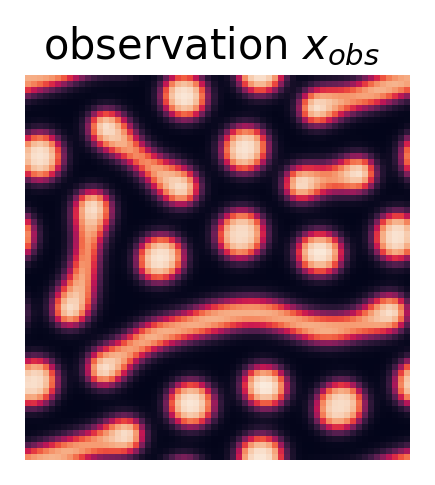

In [40]:
# | label: fig-obs-spot-strip-mix
# | fig-cap: "Observation"
# | fig-alt: "mix of spots and stripes"
plot_obs(obs_idx, dpi=250)

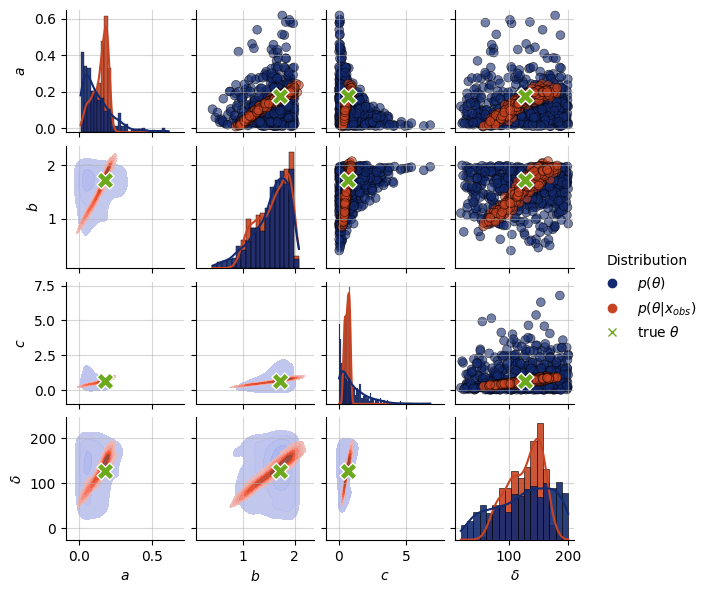

In [41]:
# | label: fig-inference
# | fig-cap: "Prior & posterior distributions; true parameter"
plot_posterior(obs_idx, height=1.5, dpi=150)

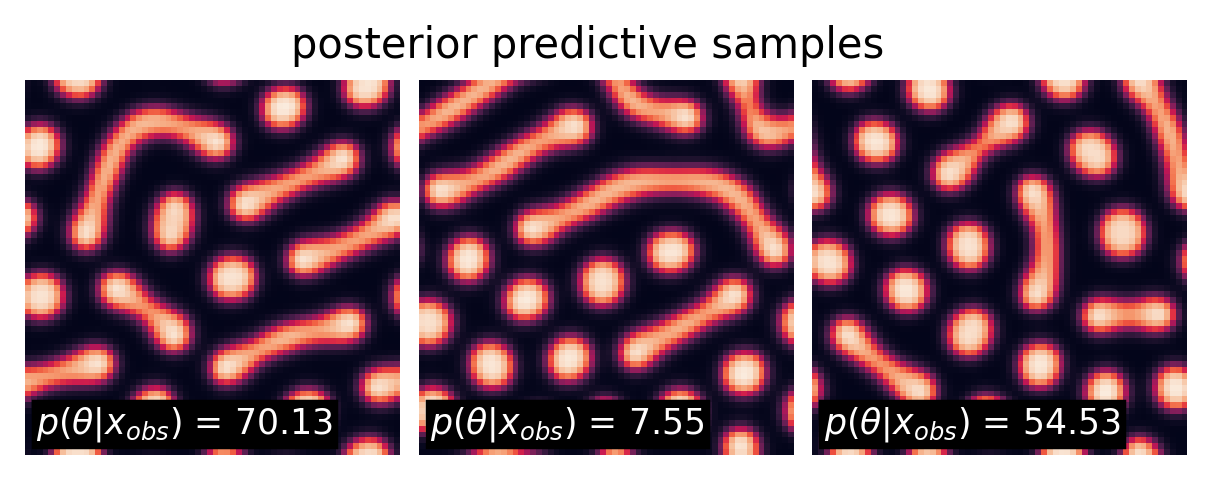

In [42]:
# | label: fig-resim-spot-strip-mix
# | fig-cap: "Resimulation"
# | fig-alt: "mix of spots and stripes"
plot_resims(obs_idx, 3, dpi=250)

In [43]:
obs_idx = 8

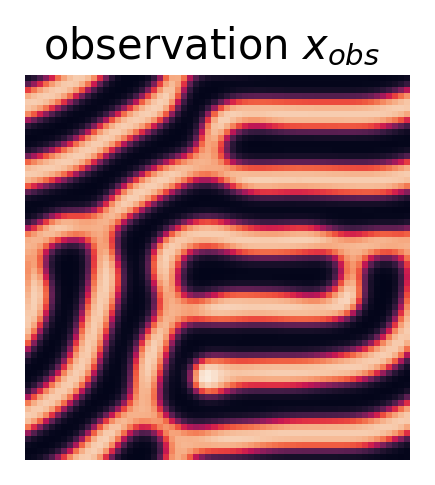

In [44]:
# | label: fig-obs-laby
# | fig-cap: "Observation"
# | fig-alt: "Labyrinthine pattern"
plot_obs(obs_idx, dpi=250)

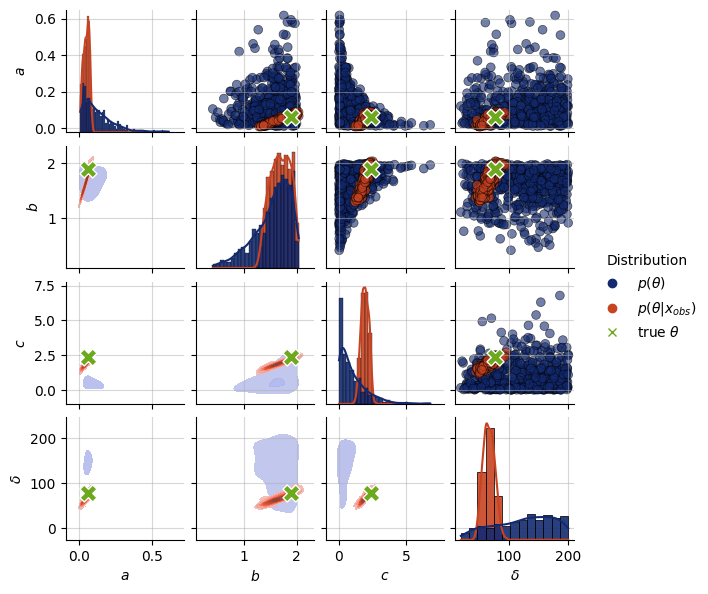

In [45]:
# | label: fig-inference-laby
# | fig-cap: "Prior & posterior distributions; true parameter"
plot_posterior(obs_idx, height=1.5, dpi=150)

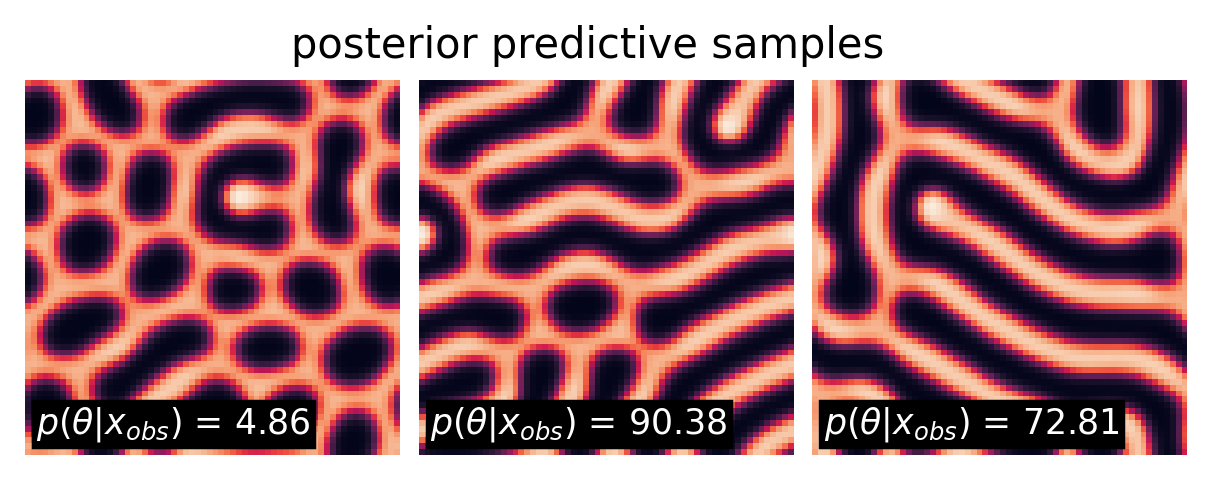

In [46]:
# | label: fig-resim-laby
# | fig-cap: "Resimulation"
# | fig-alt: "mix of spots and stripes"
plot_resims(obs_idx, 3, dpi=250)

## Point estimation

In [47]:
q_levels = np.linspace(0.1, 0.9, 5)

point_inference_network = bf.networks.PointInferenceNetwork(
    scores=dict(
        mean=bf.scores.MeanScore(),
        quantiles=bf.scores.QuantileScore(q_levels),
    ),
)

In [48]:
summary_net.net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (32, 64, 64, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 62, 62, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 31, 31, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 29, 29, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4608)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 15)               │        69,135 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 6)                │            96 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,047 (343.93 KB)

 Trainable params: 88,047 (343.93 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
summary_net.trainable = False  # Freeze the layer

In [50]:
point_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=point_inference_network,
    checkpoint_filepath="checkpoints",
    checkpoint_name="point_0",
)

Existing checkpoints can _not_ be restored/loaded using this workflow. Upon refitting, the checkpoints will be overwritten. To load the stored approximator from the checkpoint, use approximator = keras.saving.load_model(...)


In [51]:
history = point_workflow.fit_offline(
    train_dict,
    epochs=10,
    batch_size=batch_size,
    validation_data=val_dict,
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.3262 - loss/inference_loss: 0.3262 - mean/inference_mean: 0.4417 - quantiles/inference_quantiles: 0.2108 - val_loss: 0.2234 - val_loss/inference_loss: 0.2234 - val_mean/inference_mean: 0.2936 - val_quantiles/inference_quantiles: 0.1532
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.2026 - loss/inference_loss: 0.2026 - mean/inference_mean: 0.2634 - quantiles/inference_quantiles: 0.1417 - val_loss: 0.2268 - val_loss/inference_loss: 0.2268 - val_mean/inference_mean: 0.3053 - val_quantiles/inference_quantiles: 0.1482
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.1941 - loss/inference_loss: 0.1941 - mean/inference_mean: 0.2562 - quantiles/inference_quantiles: 0.1321 - val_loss: 0.1939 - val_loss/inference_loss: 0.1939 - val_mean/inference_mean: 0.2553 - val_quantiles/inference_quantiles: 0.1326
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.1900 - loss/inference_loss: 0.1900 - mean/infere

INFO:bayesflow:Training is now finished.
            You can find the trained approximator at 'checkpoints/point_0.point_0.keras'.
            To load it, use approximator = keras.saving.load_model(...).


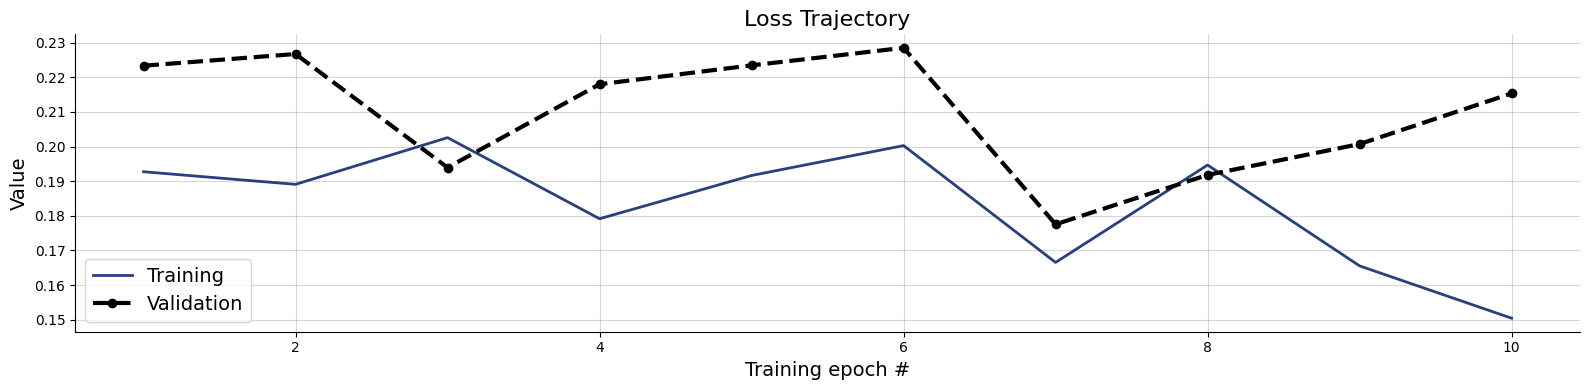

In [52]:
f = bf.diagnostics.loss(history)

In [53]:
estimates_point = point_workflow.approximator.estimate(conditions={k: v for k, v in val_dict.items()})

2025-03-17 17:27:56.178740: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 984064000 exceeds 10% of free system memory.
2025-03-17 17:27:56.379474: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 984064000 exceeds 10% of free system memory.
2025-03-17 17:27:56.654400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 984064000 exceeds 10% of free system memory.


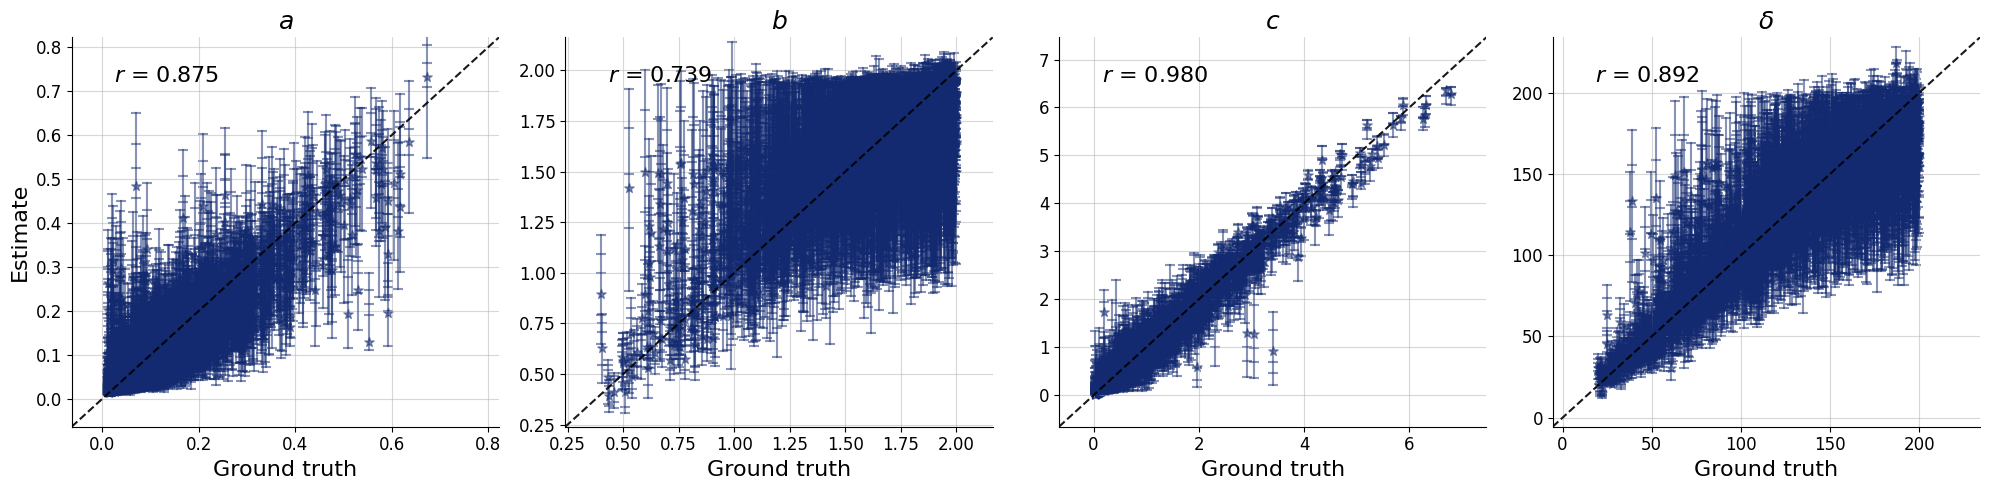

In [54]:
marker_mapping = dict(quantiles="_", mean="*")
f = bf.diagnostics.plots.recovery_from_estimates(
    estimates=estimates_point,
    targets=val_dict,
    marker_mapping=marker_mapping,
    s=50,  # size of markers as in matplotlib.scatter
    variable_names=variable_names,
)

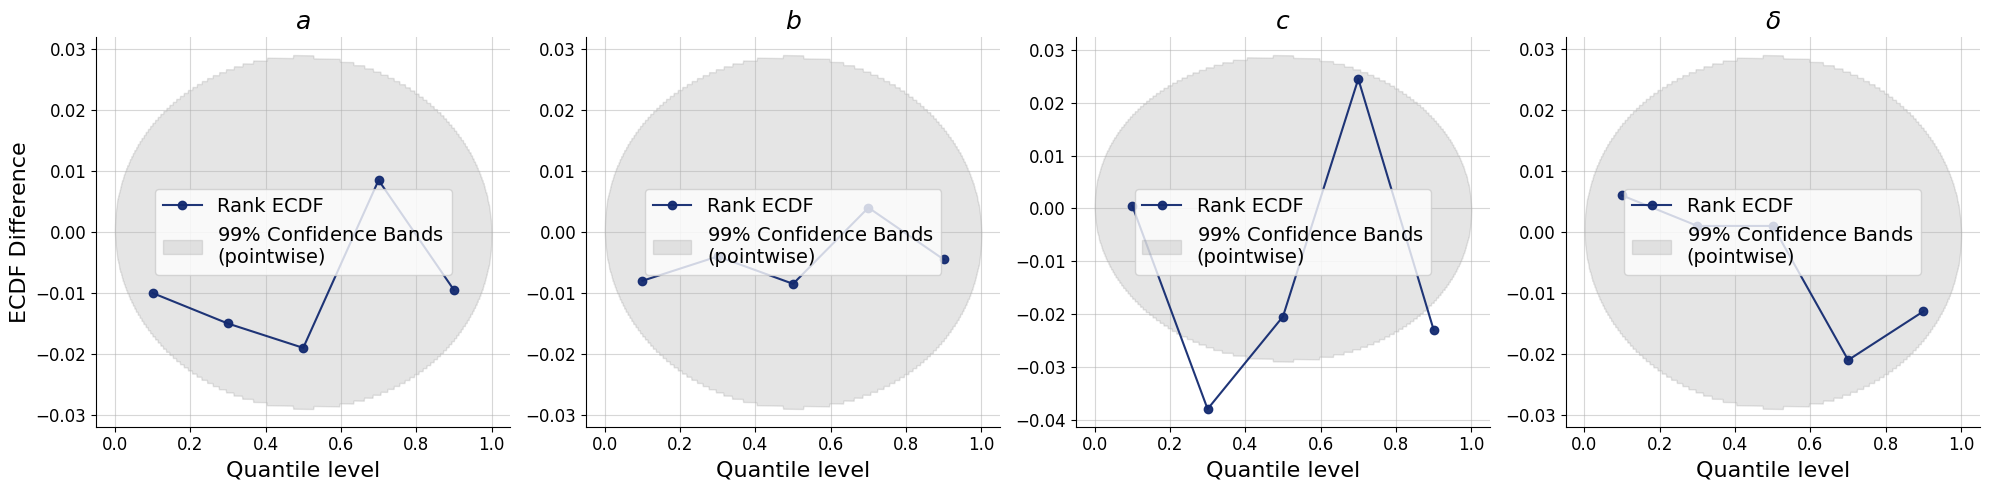

In [55]:
bf.diagnostics.plots.calibration_ecdf_from_quantiles(
    estimates=estimates_point,
    targets=val_dict,
    quantile_levels=q_levels,
    difference=True,
    variable_names=variable_names,
)
plt.show()